# Multi-Layer Perceptron

Each neuron has multiple inputs and a single output. The output is passed through an **activation function**, such as sigmoid, ReLU, or tanh.

In a Multi-Layer Perceptron (MLP), also called a *fully connected perceptron*, each neuron is connected to **all neurons in the previous layer**.

An MLP typically consists of an **input layer**, one or more **hidden layers**, and an **output layer**.  
In this implementation, we use **only one hidden layer**.


### My Implementation

- Each neuron in the hidden layer receives the input features, forms a **linear combination** using its weights, and then applies the **sigmoid activation function**:

$$
o_1 = \sigma(W_1 X + b_1)
$$

- The output layer receives the hidden layer activations. Since this is **regression**, the single output neuron forms a **linear combination** of its inputs using its own weights, without an activation function:

$$
\text{Output} = W_2 o_1 + b_2
$$


### Parameters and Shapes

#### $W_1$: Weight matrix of the hidden layer

$$
W_1 =
\begin{bmatrix}
w_{11} & w_{12} & w_{13} & \dots \\
w_{21} & w_{22} & w_{23} & \dots \\
w_{31} & w_{32} & w_{33} & \dots \\
w_{41} & w_{42} & w_{43} & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}, \quad
W_1 \in \mathbb{R}^{\text{hidden\_num} \times \text{input\_num}}
$$

- Each **row** corresponds to the weights of a hidden neuron  
- Each **column** corresponds to the weight for an input feature  


#### $W_2$: Weight matrix of the output layer

$$
W_2 =
\begin{bmatrix}
w_1 & w_2 & w_3 & w_4 & \dots
\end{bmatrix}, \quad
W_2 \in \mathbb{R}^{1 \times \text{hidden\_num}}
$$

- Applied to hidden layer outputs to compute the final linear combination  


#### $b_1$: Bias vector of the hidden layer

$$
b_1 =
\begin{bmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
\vdots
\end{bmatrix}, \quad
b_1 \in \mathbb{R}^{\text{hidden\_num} \times 1}
$$


#### $b_2$: Bias of the output neuron


$$
b_2 \in \mathbb{R}^{1 \times 1}
$$

---

### Feedforward
Feedforward refers to the process of passing input data through the network layer by layer, applying the corresponding activation functions, until reaching the output layer:
$$
\text{Output} = W_2 \, \sigma(W_1 X + b_1) + b_2
$$
where $\sigma$ is the activation function of the hidden layer.

**Purpose:** It allows the network to compute its prediction based on the current parameters.


### Backpropagation
Backpropagation is the process of computing the gradients of the cost function with respect to the network parameters, starting from the output layer and moving backward through the hidden layers to the input layer.  

**Purpose:** It provides the information needed to update the parameters via optimization (gradient descent in this implementaion), enabling the network to learn from its errors.

#### Backpropagation Derivatives

If we calculate the derivatives starting from the loss function, the gradients of the loss with respect to the weights and biases for the 2-layer network are:

$$
\frac{\partial \mathcal{L}}{\partial W_2} = (\hat{y} - y) \, (o_1)^\top
$$

$$
\frac{\partial \mathcal{L}}{\partial b_2} = (\hat{y} - y)
$$

$$
\frac{\partial \mathcal{L}}{\partial W_1} = \big(W_2^\top (\hat{y} - y) \odot o_1'\big) \, X^\top
$$

$$
\frac{\partial \mathcal{L}}{\partial b_1} = W_2^\top (\hat{y} - y) \odot o_1'
$$

**Notes:**
- $o_1 = \sigma(W_1 X + b_1)$ is the hidden layer output, and $o_1' = \sigma'(W_1 X + b_1)$ is its derivative.
- $\odot$ denotes element-wise multiplication (Hadamard product).
- These gradients are used to update the weights and biases during gradient descent.


In [1]:
import numpy as np

In [2]:
class MLP:
    def __init__(self, input_num, hidden_num):
        self.W1 = np.random.randn(hidden_num, input_num)
        self.b1 = np.random.randn(hidden_num, 1) 
        self.W2 = np.random.randn(1, hidden_num)   
        self.b2 = np.random.randn(1)
        self.loss_history = []

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def feed_forward(self, X):
        self.Z1 = self.W1 @ X + self.b1
        self.o1 = self.sigmoid(self.Z1)
        self.Z2 = self.W2 @ self.o1 + self.b2
        self.Output = self.Z2
        return self.Output

    def backpropagation(self, X, Y, learning_rate):
        m = X.shape[1]
        dW2 = (1/m) * (self.Output - Y) @ self.o1.T
        db2 = (1/m) * np.sum(self.Output - Y, axis=1, keepdims=True)
        dW1 = (1/m) * ((self.W2.T @ (self.Output - Y)) * self.sigmoid_derivative(self.Z1)) @ X.T
        db1 = (1/m) * np.sum((self.W2.T @ (self.Output - Y)) * self.sigmoid_derivative(self.Z1), axis=1, keepdims=True)
        self.W2 = self.W2 - learning_rate * dW2
        self.b2 = self.b2 - learning_rate * db2
        self.W1 = self.W1 - learning_rate * dW1
        self.b1 = self.b1 - learning_rate * db1


    def fit(self, X, Y, epochs=1, learning_rate=0.01, batch_size=None):
        m = X.shape[1]
        if batch_size is None:
            batch_size = m
        for epoch in range(epochs):
            epoch_loss , num_batches = 0,0
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                Y_batch = Y_shuffled[:, i:i+batch_size]
                y_pred = self.feed_forward(X_batch)
                loss = self.mse_loss(Y_batch, y_pred)
                self.backpropagation(X_batch, Y_batch, learning_rate)
                epoch_loss += loss
                num_batches += 1
            self.loss_history.append(epoch_loss / num_batches)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / num_batches:.4f}")


    def predict(self, X):
        return self.feed_forward(X)

In [3]:
#Generating a 1D featue data randomly and then add noise to the target (you can use multi-dimentional features with this model)

X = np.linspace(0, 5, 1000).reshape(1, -1)
np.random.seed(42)
noise = 1.8 * (np.random.randn(1, 1000))
Y = 3 * X + 2 + noise

# making the model and train
mlp = MLP(input_num=1, hidden_num=5)
mlp.fit(X, Y, epochs=100, learning_rate=0.1, batch_size= 32)

Epoch 1/100, Loss: 11.4549
Epoch 2/100, Loss: 4.2325
Epoch 3/100, Loss: 4.1063
Epoch 4/100, Loss: 3.8982
Epoch 5/100, Loss: 4.2445
Epoch 6/100, Loss: 3.5306
Epoch 7/100, Loss: 3.9759
Epoch 8/100, Loss: 3.9118
Epoch 9/100, Loss: 3.6669
Epoch 10/100, Loss: 3.6637
Epoch 11/100, Loss: 3.8640
Epoch 12/100, Loss: 3.6194
Epoch 13/100, Loss: 3.6445
Epoch 14/100, Loss: 3.5633
Epoch 15/100, Loss: 3.6943
Epoch 16/100, Loss: 3.7214
Epoch 17/100, Loss: 3.4787
Epoch 18/100, Loss: 3.6752
Epoch 19/100, Loss: 3.4190
Epoch 20/100, Loss: 3.5147
Epoch 21/100, Loss: 3.4595
Epoch 22/100, Loss: 3.4049
Epoch 23/100, Loss: 3.3728
Epoch 24/100, Loss: 3.6573
Epoch 25/100, Loss: 3.4835
Epoch 26/100, Loss: 3.4141
Epoch 27/100, Loss: 3.5031
Epoch 28/100, Loss: 3.3698
Epoch 29/100, Loss: 3.4190
Epoch 30/100, Loss: 3.3927
Epoch 31/100, Loss: 3.2019
Epoch 32/100, Loss: 3.4575
Epoch 33/100, Loss: 3.3804
Epoch 34/100, Loss: 3.2056
Epoch 35/100, Loss: 3.2144
Epoch 36/100, Loss: 3.5344
Epoch 37/100, Loss: 3.2860
Epoch 38/

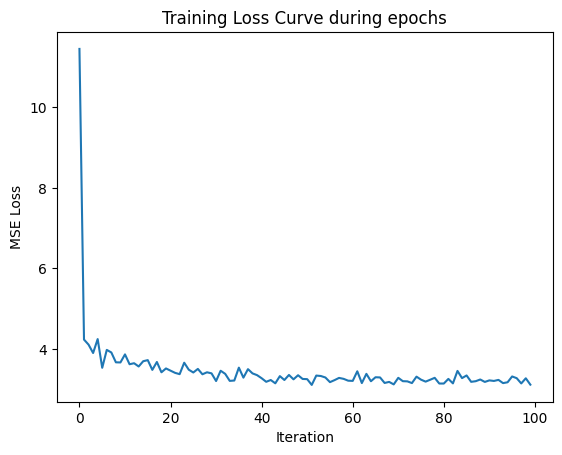

In [4]:
import matplotlib.pyplot as plt
# Plotting the losses during training period
plt.plot(mlp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve during epochs")
plt.show()

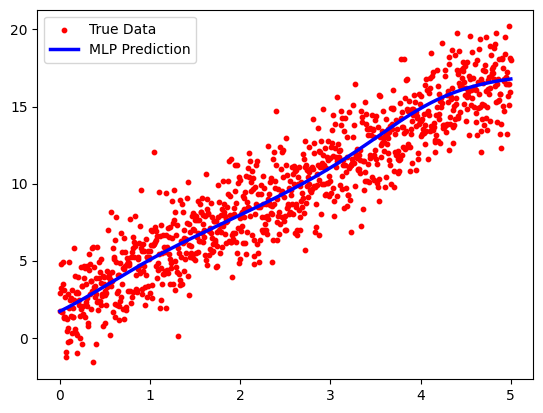

In [5]:
#Making predictions
Y_pred = mlp.predict(X)

plt.scatter(X.flatten(), Y.flatten(), label="True Data", s = 10, color = 'red')
plt.plot(X.flatten(), Y_pred.flatten(), color="blue", label="MLP Prediction", linewidth = 2.5)
plt.legend()
plt.show()